In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Решение задачи с выделением масок изображений
Дмитрий Рудик.

Задача на сегодняшний день довольно известная и в рамках таких пакетов, как PyTorch предлагаются встроенные решения.
Кроме того, непосредственно в репозитории с данными лежит решение использующее Mask R-CNN. Данная сеть широко используется для решения задачи сегментации изображения (https://habr.com/ru/post/421299/ или https://arxiv.org/abs/1703.06870).

В ходе решения задачи возникло несколько проблем:

1.   На локальном компьютере у меня был установлен Python 2.7, что было необходимо для моей работы. Пытаясь реализовать на нем решение с использованием PyTorch, я получил ошибку 
```
RuntimeError: No such operator torchvision::nms
```
(https://github.com/pytorch/vision/issues/1916). Данная ошибка является багом PyTorch старых версий и/или зависимостей с другими модулями Python. Была решена для Python3, но для моей версии Python осталась нерешенной.
2.   Решение, предлагаемое непосредственно на сайте с данными, генерировало ошибку загрузки модуля urllib, что, видимо тоже связано с версией Python.
3.   Мной было принято решение перейти на colab.research.google.com для дальнейшей реализации задачи. К сожалению, к этому моменту очень много времени было потеряно на борьбу с устаревшим софтом и нарушенными зависимостями.

Таким образом, на данный момент (19:00 22 октября 2020) задача не решена в полном объеме.

Тем не менее, было реализовано следующее:


1.   Найден и опробован пример из документации PyTorch для задачи сегментации изображений с пешеходами
2.   Написан класс CigaretteSegmDataset по аналогии с классом данных из указанной документации
3.   Реализована заготовка решения, использующая модель 
```
MaskRCNNPredictor
```
4.   Исправлены ошибки, опечатки и модель запущена на обучение, чтобы получить предварительные результаты (однако, судя по всему, до дедлайна обучиться она не успеет).

Т.е. на данный момент найдено возможное решение, которое как-то работает (процесс обучения идет), и которое можно будет улучшить в будущем. К сожалению, времени на подбор или изменение предустановленных параметров сети мне не хватило по указанным выше причинам и ввиду необходимости решать задачи в рамках основной работы.

Буду благодарен за обратную связь.

In [2]:
#Imoprt non-Pytorch Modules

import os
os.chdir("/content/drive/My Drive/cv_test/cigarette_butt_segmentation")

import time
import cv2
import json
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont

from glob import glob


from lib import *

%matplotlib inline

In [3]:
# Import PyTorch Modules will be used in the solution

import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
#from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

# Класс данных CigaretteSegmDataset

In [4]:
train_data_dir = "data/train/"
validation_data_dir = "data/val/"

In [5]:
class CigaretteSegmDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = list(sorted(os.listdir(data_dir+"images")))
        self.annotations = json.load(open(data_dir+"coco_annotations.json", "r"))
        self.len = len(self.images)
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Get Item
    def __getitem__(self, idx):
        img_name = self.data_dir+"images/"+self.images[idx]
        image = Image.open(img_name).convert("RGB")
        mask = get_mask(idx, self.annotations)
        
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = mask == obj_ids[:, None, None]

        # only one box in this dataset for each image
        bbox = self.annotations["annotations"][idx]["bbox"]
        xmin = bbox[0]
        xmax = bbox[0] + bbox[2]
        ymin = bbox[1] - bbox[3]
        ymax = bbox[1]
        
        box = []
        box.append([xmin, ymin, xmax, ymax])
        
        area = []
        area.append(self.annotations["annotations"][idx]["area"])

        # convert everything into a torch.Tensor
        box = torch.as_tensor(box, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = box
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform is not None:
            image, target = self.transform(image, target)

        return image, target
    
    # use class method for showing img with mask
    def show(self, img_id):
        img_name = self.data_dir+"images/"+self.images[img_id]
        image = np.array(Image.open(img_name))
        mask = get_mask(img_id, self.annotations)
        show_img_with_mask(image, mask)



In [6]:
import lib.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
train_dataset = CigaretteSegmDataset(data_dir = train_data_dir, transform=get_transform(train=True))
validation_dataset = CigaretteSegmDataset(data_dir = validation_data_dir, transform=get_transform(0))

In [8]:
len(validation_dataset)

200

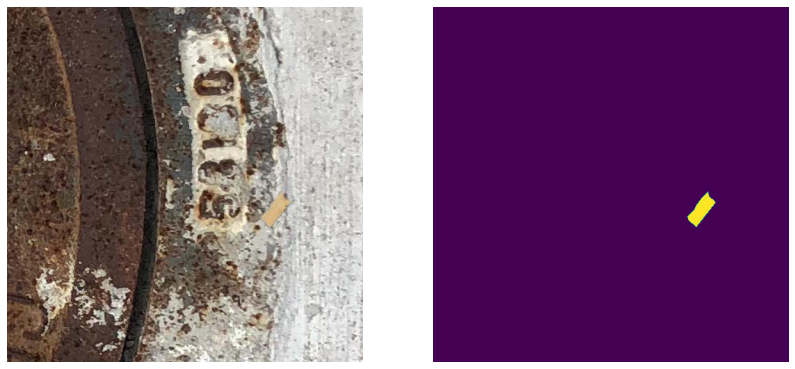

In [9]:
train_dataset.show(2)

# Загружаем модель MaskRCNNPredictor

Изначало модель рассчитана на сегментацию 1000 классов. Т.к. у нас задача стоит определять только окурки на фоне, то необходимо уменьшить количество классов до 2х (фон, объект) и уменьшить количество нейронов в hidden layer. На данный момент оставил 256 нейронов. Однако, с этот параметр в будущем можно было бы поварьировать.

In [10]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_classes = 2

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

Загатовка дополнительного критерия на основе Dice метрики. Загрузка данных, количество эпох.

In [11]:
def criterion (pred_mask, real_mask):
    return 1 - get_dice(pred_mask,real_mask)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = 20, num_workers=4, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, shuffle=True, batch_size = 10, num_workers=4, collate_fn=collate_fn)

params = [parameters for parameters in model.parameters() if parameters.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.5,
                                momentum=0.9, weight_decay=0.05)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)

N_EPOCHS = 5
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)
threshold = 0.7

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

Используем некоторый функционал из репозитория TorchVision.

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [12]:
from engine import train_one_epoch, evaluate
import utils

# Обучаем модель.

In [ ]:
for epoch in range(N_EPOCHS):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, validation_loader, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [  0/100]  eta: 3:09:25  lr: 0.005545  loss: 2.5835 (2.5835)  loss_classifier: 0.0968 (0.0968)  loss_box_reg: 0.0260 (0.0260)  loss_mask: 2.2900 (2.2900)  loss_objectness: 0.1630 (0.1630)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 113.6518  data: 1.9923
Epoch: [0]  [ 10/100]  eta: 2:44:25  lr: 0.056000  loss: 1.5324 (1.6092)  loss_classifier: 0.0636 (0.0675)  loss_box_reg: 0.0130 (0.0139)  loss_mask: 1.3218 (1.3689)  loss_objectness: 0.1630 (0.1505)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 109.6139  data: 0.2238
Epoch: [0]  [ 20/100]  eta: 2:26:19  lr: 0.106455  loss: 1.5642 (2.1993)  loss_classifier: 0.0590 (0.0641)  loss_box_reg: 0.0111 (0.0129)  loss_mask: 1.3241 (1.9615)  loss_objectness: 0.1525 (0.1526)  loss_rpn_box_reg: 0.0076 (0.0082)  time: 109.5521  data: 0.0536
Epoch: [0]  [ 30/100]  eta: 2:07:44  lr: 0.156909  loss: 1.3265 (1.9231)  loss_classifier: 0.0588 (0.0637)  loss_box_reg: 0.0107 (0.0124)  loss_mask: 1.0308 (1.6842)  loss_objectness: 0.1555 (0.1543)  loss